# Import Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

# Data Preprocessing

# Training Image preprocessing

In [2]:
train_dir = r"C:\Users\USER\Desktop\My Drive\Project\Plant Disease recognition\archive\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"
val_dir = r"C:\Users\USER\Desktop\My Drive\Project\Plant Disease recognition\archive\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid"

In [3]:
# Create training data generator
train_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(128, 128),
    shuffle=True,
    seed=42,  # Set seed for reproducibility
    validation_split=0.2,  # 20% for validation
    subset="training",  # Specify this is training subset
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 64427 files belonging to 38 classes.
Using 51542 files for training.


# Validation Image preprocessing

In [4]:
# Create validation data generator
val_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,  
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(128, 128),
    shuffle=True,
    seed=42,  # Use same seed as training
    validation_split=0.2,
    subset="validation",  
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 64427 files belonging to 38 classes.
Using 12885 files for validation.


In [5]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_generator = train_generator.cache().prefetch(buffer_size=AUTOTUNE)
val_generator = val_generator.cache().prefetch(buffer_size=AUTOTUNE)

# Add data augmentation 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Apply augmentation to training data
train_generator = train_generator.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

# Normalize the data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_generator = train_generator.map(lambda x, y: (normalization_layer(x), y))
val_generator = val_generator.map(lambda x, y: (normalization_layer(x), y))

In [6]:
for x,y in train_generator:
    print(x,x.shape)
    print(y,y.shape)
    break

tf.Tensor(
[[[[0.28235912 0.4791053  0.36411536]
   [0.29042816 0.48843008 0.3708576 ]
   [0.30284786 0.50270665 0.38144335]
   ...
   [0.34177187 0.554537   0.41212523]
   [0.32376903 0.535244   0.40575242]
   [0.32075697 0.53148675 0.40625343]]

  [[0.2746167  0.47069514 0.3583337 ]
   [0.28401545 0.48080808 0.36565417]
   [0.29622605 0.49513593 0.37574747]
   ...
   [0.3401967  0.55417615 0.40354645]
   [0.33444077 0.5465526  0.40997377]
   [0.31966695 0.53076565 0.4048182 ]]

  [[0.27004272 0.46612114 0.35688084]
   [0.28414816 0.48034382 0.36690432]
   [0.2906234  0.48828888 0.3713893 ]
   ...
   [0.34347358 0.55867976 0.40119052]
   [0.34387016 0.55704445 0.41172534]
   [0.3236274  0.5353789  0.40383872]]

  ...

  [[0.30536708 0.51713175 0.46615136]
   [0.3076351  0.51939976 0.46841943]
   [0.31763858 0.52940327 0.47842288]
   ...
   [0.37469804 0.5825412  0.51979613]
   [0.38617417 0.5940173  0.5312723 ]
   [0.3853893  0.59323245 0.53048736]]

  [[0.3116734  0.52343816 0.472457

# Bulding the Model 

In [7]:
from tensorflow.keras import layers, regularizers, Sequential

def create_optimized_cnn(input_shape=(128, 128, 3), num_classes=38):
    model = Sequential()
    
    # Initial Conv block with smaller filters
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=regularizers.l2(0.0005), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Second block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    # Third block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.35))
    
    # Fourth block
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    
    # Fifth block for deeper features
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    
    # Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Create model instance
model = create_optimized_cnn()


# Compiling the model

In [8]:
from tensorflow.keras.metrics import Precision, Recall, AUC, TopKCategoricalAccuracy

# Define the metrics
metrics = [
    'accuracy',                             # Basic accuracy
    Precision(name='precision'),            # Precision
    Recall(name='recall'),                  # Recall
    AUC(name='auc'),                        # AUC-ROC
    TopKCategoricalAccuracy(k=3, name='top_k_categorical_accuracy'),  # Top-3 Accuracy
]

# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(clipnorm=1.0), 
    loss='categorical_crossentropy', 
    metrics=metrics
)


In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                      

In [10]:
# Define callbacks
callbacks = [
    # Early Stopping
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,  # Number of epochs with no improvement after which training will stop
        restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
        mode='min',
        verbose=1
    ),
    
    # Learning Rate Reduction
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # Factor by which the learning rate will be reduced
        patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-6,  # Lower bound on the learning rate
        mode='min',
        verbose=1
    ),
    
    # Model Checkpoint
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    
    # TensorBoard logging
    keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1,
        write_graph=True
    )
]

In [ ]:
# Train the model with callbacks
training_hist = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
3222/3222 [==============================] - ETA: 0s - loss: 3.8301 - accuracy: 0.3788 - precision: 0.5581 - recall: 0.2426 - auc: 0.9016 - top_k_categorical_accuracy: 0.6311
Epoch 00001: val_loss improved from inf to 5.11783, saving model to best_model.keras
3222/3222 [==============================] - 3779s 1s/step - loss: 3.8301 - accuracy: 0.3788 - precision: 0.5581 - recall: 0.2426 - auc: 0.9016 - top_k_categorical_accuracy: 0.6311 - val_loss: 5.1178 - val_accuracy: 0.3070 - val_precision: 0.3977 - val_recall: 0.2474 - val_auc: 0.8005 - val_top_k_categorical_accuracy: 0.5094 - lr: 0.0010
Epoch 2/30
3222/3222 [==============================] - ETA: 0s - loss: 2.9325 - accuracy: 0.5640 - precision: 0.6965 - recall: 0.4356 - auc: 0.9602 - top_k_categorical_accuracy: 0.8150
Epoch 00002: val_loss improved from 5.11783 to 2.92568, saving model to best_model.keras
3222/3222 [==============================] - 4462s 1s/step - loss: 2.9325 - accuracy: 0.5640 - precision: 0.6965 -

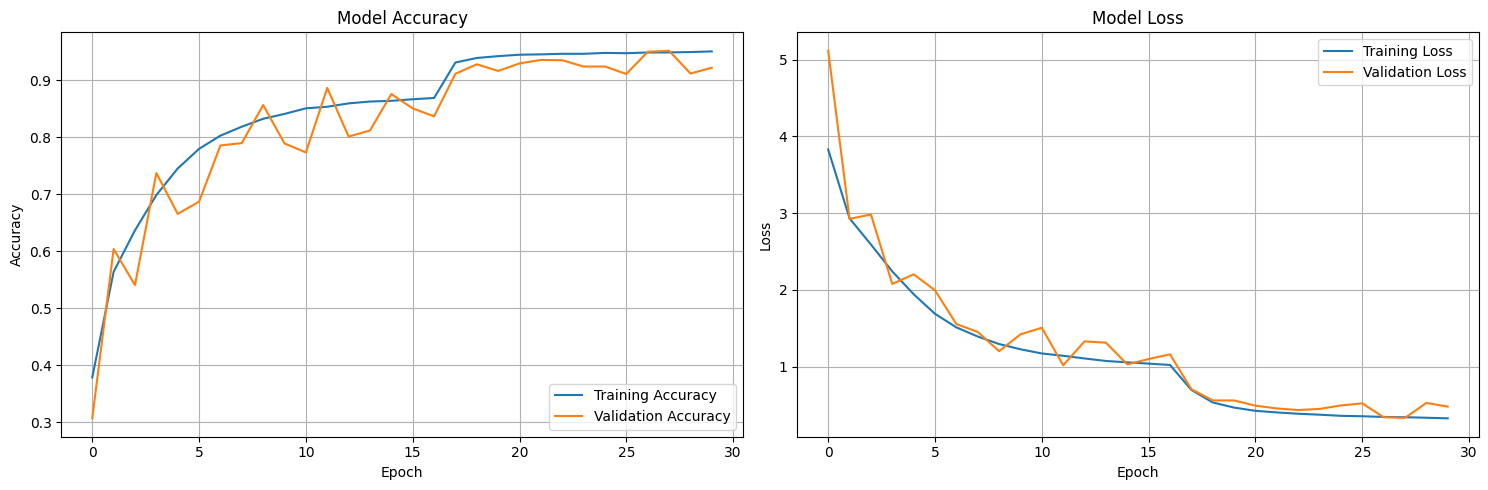


Final learning rate: 0.00020000000949949026

Best epoch: 28
Best validation loss: 0.3308
Best validation accuracy: 0.9517


In [16]:
# Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(training_hist)

# Print final learning rate
final_lr = tf.keras.backend.get_value(model.optimizer.lr)
print(f"\nFinal learning rate: {final_lr}")

# Print best epoch's metrics
best_epoch = np.argmin(training_hist.history['val_loss']) + 1
print(f"\nBest epoch: {best_epoch}")
print(f"Best validation loss: {min(training_hist.history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(training_hist.history['val_accuracy']):.4f}")

In [18]:
# model evaluation on training set
# Print all evaluation results
results = model.evaluate(train_generator)
print("All returned values:", results)
print("Number of metrics:", len(results))
print("Metrics names:", model.metrics_names)

3222/3222 [==============================] - 1430s 444ms/step - loss: 0.2315 - accuracy: 0.9788 - precision: 0.9812 - recall: 0.9763 - auc: 0.9994 - top_k_categorical_accuracy: 0.9986
All returned values: [0.23146989941596985, 0.9788327813148499, 0.9811843037605286, 0.9763299822807312, 0.9993974566459656, 0.998622477054596]
Number of metrics: 6
Metrics names: ['loss', 'accuracy', 'precision', 'recall', 'auc', 'top_k_categorical_accuracy']


In [19]:
train_loss, training_acc, *other_metrics = model.evaluate(train_generator)

3222/3222 [==============================] - 1379s 427ms/step - loss: 0.2313 - accuracy: 0.9780 - precision: 0.9808 - recall: 0.9762 - auc: 0.9994 - top_k_categorical_accuracy: 0.9988


In [20]:
# model evaluation on validation set
val_loss,val_acc,*other_metrics = model.evaluate(val_generator)

806/806 [==============================] - 9721s 12s/step - loss: 0.4774 - accuracy: 0.9218 - precision: 0.9292 - recall: 0.9183 - auc: 0.9908 - top_k_categorical_accuracy: 0.9915


In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

def load_and_preprocess_images(image_paths, target_size=(150, 150)):
    """Load and preprocess a list of images."""
    images = []
    
    for img_path in image_paths:
        try:
            # Load and resize image
            img = load_img(img_path, target_size=target_size)
            # Convert to array and rescale
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
    
    return np.array(images)



Found 33 images
Loaded images shape: (33, 150, 150, 3)


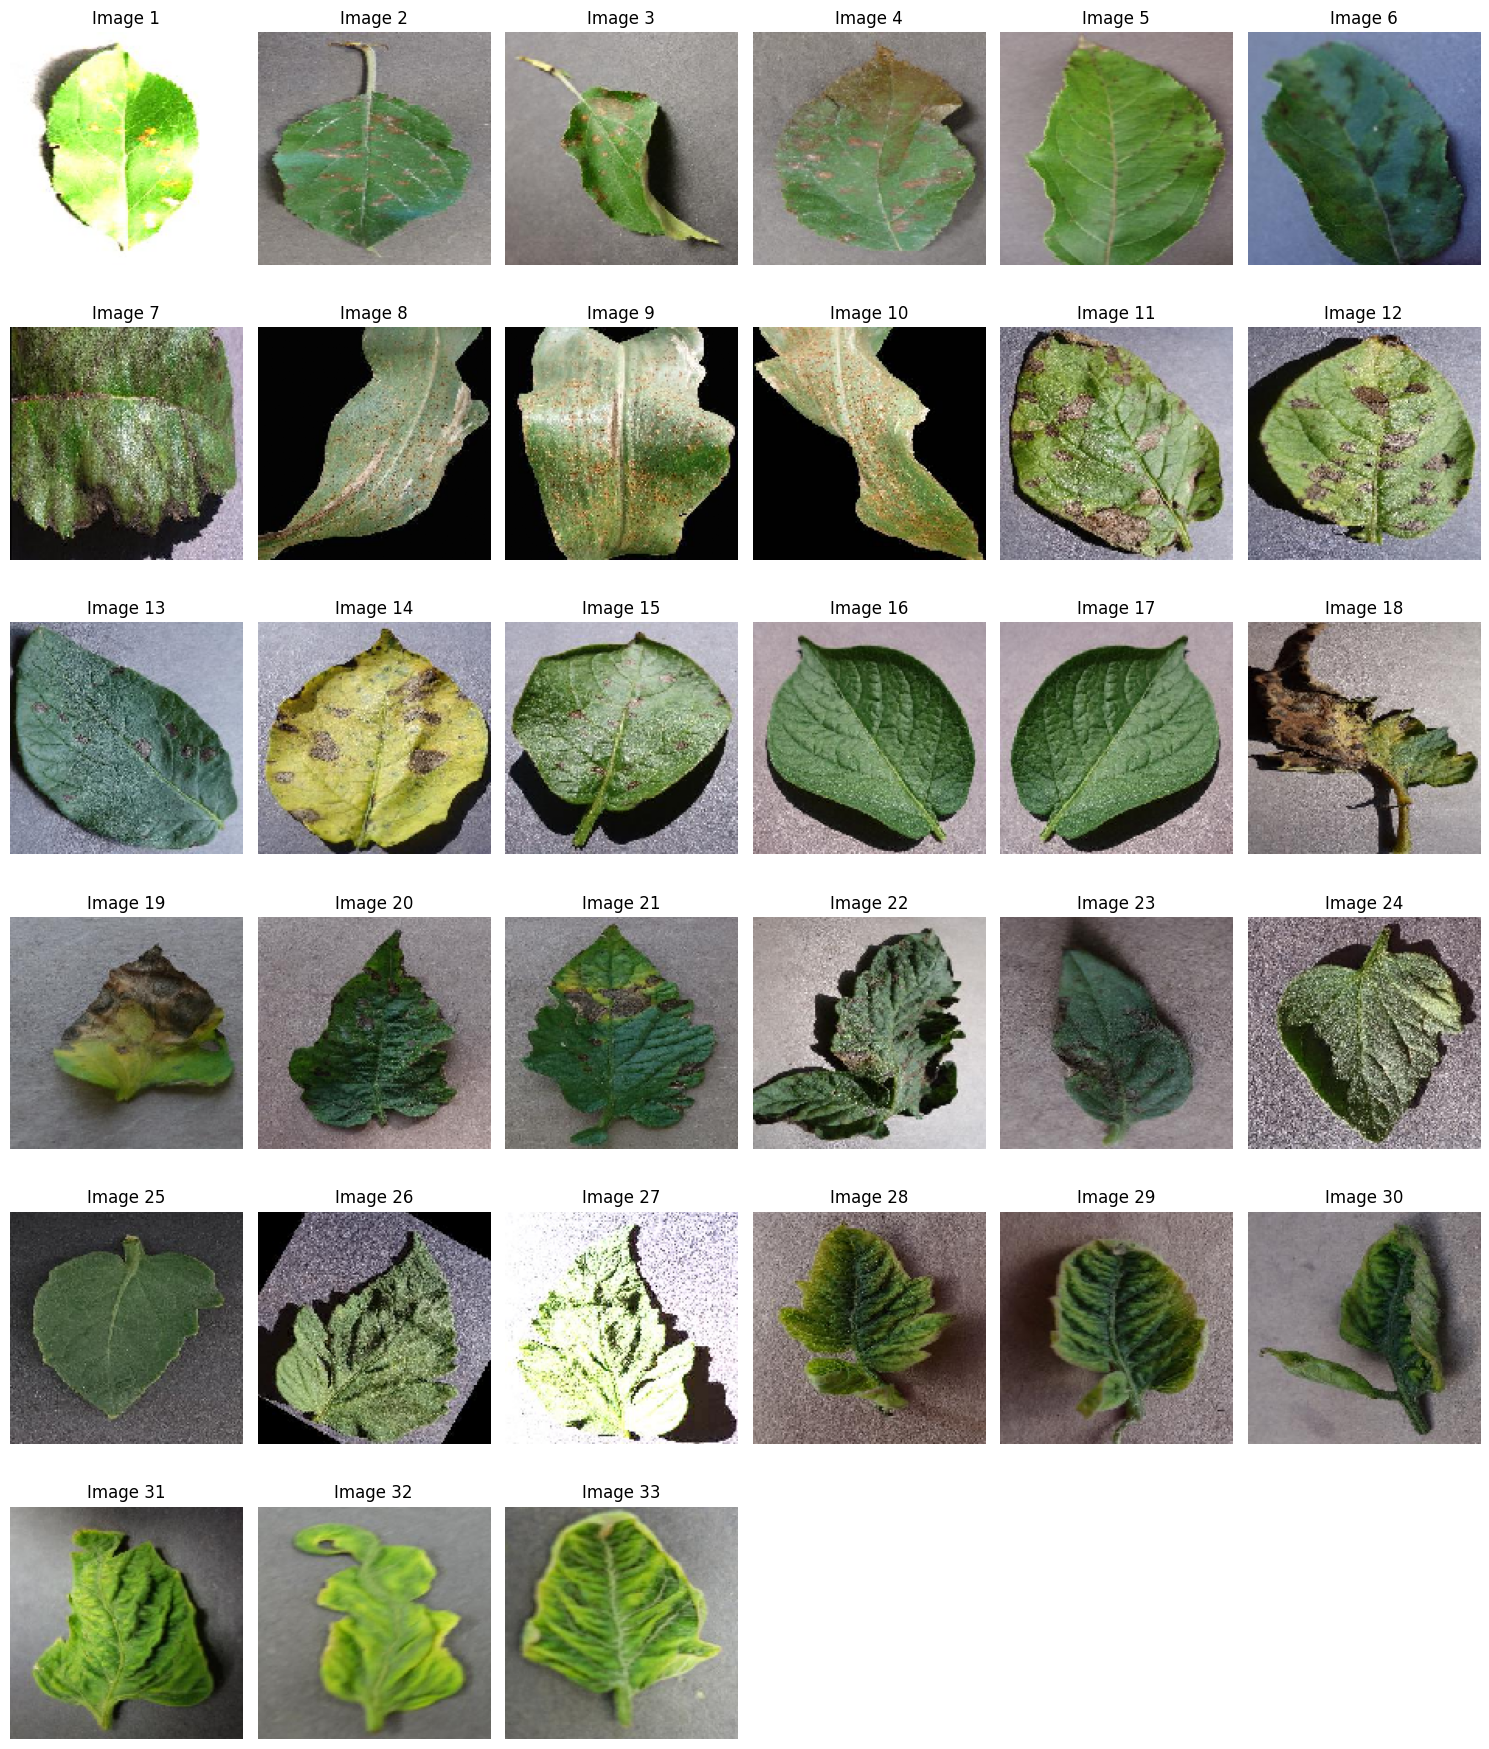


Image array shape: (33, 150, 150, 3)
Number of images: 33
Image dimensions: (150, 150, 3)

First few image paths:
C:\Users\USER\Desktop\test\AppleCedarRust1.JPG
C:\Users\USER\Desktop\test\AppleCedarRust2.JPG
C:\Users\USER\Desktop\test\AppleCedarRust3.JPG
C:\Users\USER\Desktop\test\AppleCedarRust4.JPG
C:\Users\USER\Desktop\test\AppleScab1.JPG


In [35]:
# Define the path to the directory
path = r"C:\Users\USER\Desktop\test"

# Find all image files recursively
image_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} images")

# Load and preprocess images
images = load_and_preprocess_images(image_files)
print(f"Loaded images shape: {images.shape}")

# Display all images
if len(images) > 0:
    # Calculate grid dimensions
    n_cols = min(6, len(images))
    n_rows = (len(images) + n_cols - 1) // n_cols
    
    # Create figure
    plt.figure(figsize=(15, 3 * n_rows))
    
    # Plot each image
    for idx in range(len(images)):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(images[idx])
        plt.title(f"Image {idx + 1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print shape information
    print("\nImage array shape:", images.shape)
    print("Number of images:", len(images))
    print("Image dimensions:", images[0].shape)
    
    # Print first few file paths
    print("\nFirst few image paths:")
    for path in image_files[:5]:
        print(path)
else:
    print("No images were loaded successfully")

In [37]:
print(type(images))  # <class 'numpy.ndarray'

<class 'numpy.ndarray'>


In [38]:
print(images.shape)  


(33, 150, 150, 3)


In [39]:
print(type(labels))  # <class 'numpy.ndarray'>


<class 'numpy.ndarray'>


In [44]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a single image
img_path = r"C:\Users\USER\Desktop\test\AppleCedarRust1.JPG"
img = image.load_img(img_path, target_size=(150, 150))  # Match the size used during training
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create a batch dimension
img_array /= 255.0  # Normalize (match training preprocessing)

In [46]:
from PIL import Image
import numpy as np

# Load the image
img = Image.open(r"C:\Users\USER\Desktop\test\AppleCedarRust1.JPG")

# Resize the image to 128x128
img_resized = img.resize((128, 128))

# Convert the image to a numpy array
img_array = np.array(img_resized)

# Ensure the image has 3 color channels (RGB)
if img_array.shape[2] == 4:  # If the image has an alpha channel
    img_array = img_array[:, :, :3]  # Remove the alpha channel

# Add a batch dimension
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
prediction = model.predict(img_array)


In [47]:
print(prediction)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00 1.7645565e-27 4.2001518e-28]]


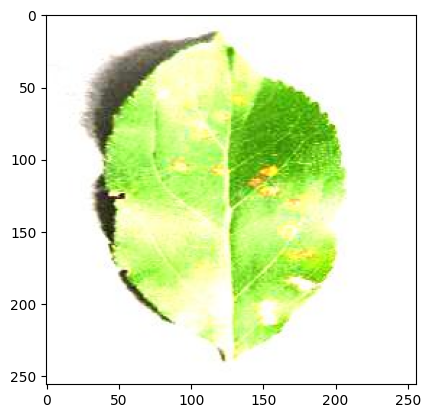

In [48]:
plt.imshow(img)

In [56]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load your pre-trained model
model = load_model('best_model.keras')

# Define the parameters for the generator
img_height = 128
img_width = 128

# Path to the directory containing images
image_directory =  r"C:\Users\USER\Desktop\IMG_TEST"

# List all image files in the directory
image_files = [f.path for f in os.scandir(image_directory) if f.is_file() and f.name.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    raise ValueError(f"No images found in the directory {image_directory}.")

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = img_array / 255.0  
    return img_array

# Make predictions for each image
for i, image_path in enumerate(image_files):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = f"Class {predicted_class_index}"  
    print(f"Image {i+1}: Predicted class is {predicted_class_label}")


Image 1: Predicted class is Class 2
Image 2: Predicted class is Class 2
Image 3: Predicted class is Class 2
Image 4: Predicted class is Class 2
Image 5: Predicted class is Class 0
Image 6: Predicted class is Class 0
Image 7: Predicted class is Class 37
Image 8: Predicted class is Class 8
Image 9: Predicted class is Class 8
Image 10: Predicted class is Class 8
Image 11: Predicted class is Class 20
Image 12: Predicted class is Class 20
Image 13: Predicted class is Class 20
Image 14: Predicted class is Class 20
Image 15: Predicted class is Class 20
Image 16: Predicted class is Class 22
Image 17: Predicted class is Class 22
Image 18: Predicted class is Class 30
Image 19: Predicted class is Class 30
Image 20: Predicted class is Class 37
Image 21: Predicted class is Class 29
Image 22: Predicted class is Class 30
Image 23: Predicted class is Class 37
Image 24: Predicted class is Class 37
Image 25: Predicted class is Class 37
Image 26: Predicted class is Class 37
Image 27: Predicted class is C

In [67]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load your pre-trained model
model = load_model('best_model.keras')


Found 16115 images belonging to 38 classes.


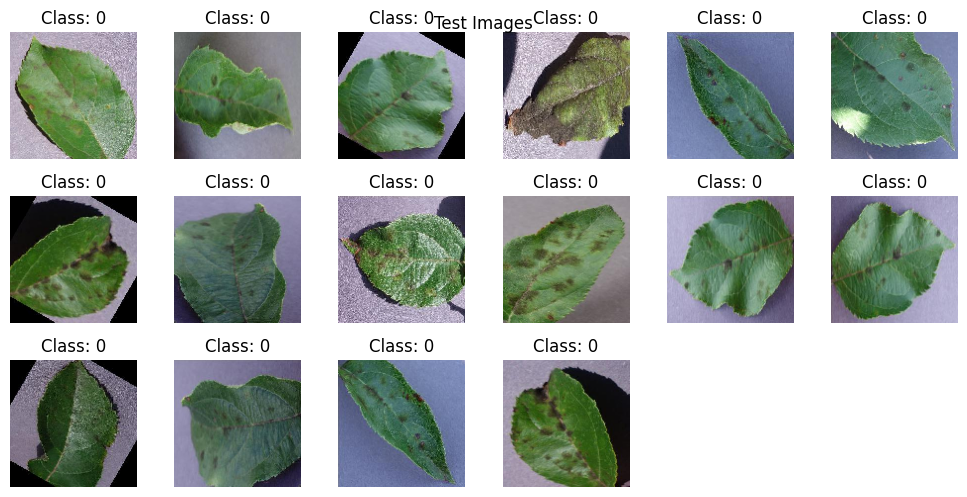

In [68]:
# Define the path to the directory
path = r"C:\Users\USER\Desktop\IMG_TEST"

# Initialize ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the generator
test_generator = test_datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=16,  # Batch size of 32
    class_mode='categorical',
    shuffle=False
)

# Get a batch of images and labels
images, labels = next(test_generator)

# Number of images to display
num_images = 36

num_images = min(num_images, images.shape[0])

# Get random indices for sampling
indices = np.random.choice(images.shape[0], num_images, replace=False)

# Plot images
plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    plt.subplot(6, 6, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Class: {np.argmax(labels[idx])}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Test Images")
plt.show()

In [69]:
print("Images shape:", images.shape)

Images shape: (16, 128, 128, 3)


In [70]:
print(type(images))  # <class 'numpy.ndarray'>
print(images.shape)  

print(type(labels))  # <class 'numpy.ndarray'>
print(labels.shape) 

<class 'numpy.ndarray'>
(16, 128, 128, 3)
<class 'numpy.ndarray'>
(16, 38)


In [73]:
# Function to load and preprocess a single image
def load_and_preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch dimension
    img_array /= 255.0  # Normalize if needed (match training preprocessing)
    return img_array

# Load and preprocess a single image
img_path = r"C:\Users\USER\Desktop\IMG_TEST\Apple___Apple_scab\0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417.JPG"
img_array = load_and_preprocess_image(img_path, target_size=(128, 128))  
# Make a prediction
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)

In [75]:
print(prediction)

[[9.8866546e-01 1.0200007e-07 2.2089178e-05 4.0447099e-05 3.7154109e-08
  5.9841102e-05 8.6482341e-06 1.8206321e-10 6.9509994e-08 2.7914526e-05
  1.8774815e-08 2.0485565e-03 9.6431668e-06 5.5798978e-06 9.2508686e-05
  8.1630846e-05 4.0627347e-06 1.0514271e-09 3.8403030e-08 9.1413570e-09
  1.5715845e-08 1.0452106e-05 5.0601875e-06 7.7967725e-06 1.3253829e-07
  8.8182762e-03 5.4081293e-06 4.1833214e-06 1.6618433e-05 2.3390950e-07
  4.3288910e-05 6.5868761e-08 3.7589705e-06 2.0015116e-10 2.1965166e-06
  1.9064338e-07 1.6842222e-08 1.5651702e-05]]


In [76]:
result_index = np.where(prediction[0]==max(prediction[0]))

In [77]:
print(result_index)

(array([0], dtype=int64),)


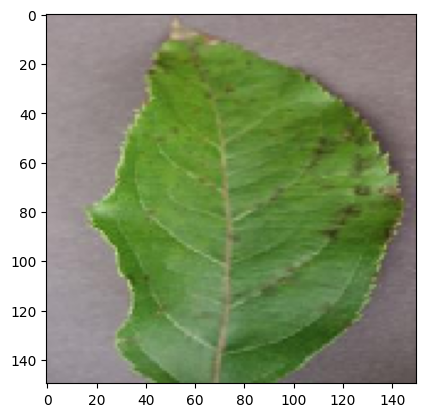

In [78]:
plt.imshow(img)

In [79]:
# Get class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

#print("Class Indices:", class_indices)
print("Class Names:", class_names)

Class Names: {0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_bli

In [80]:
class_names

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [81]:
#singe prediction
print("it's a {}".format(class_names[result_index[0][0]]))

it's a Apple___Apple_scab


In [82]:
model.evaluate(val_generator)

806/806 [==============================] - 281s 347ms/step - loss: 0.3308 - accuracy: 0.9517 - precision: 0.9574 - recall: 0.9485 - auc: 0.9971 - top_k_categorical_accuracy: 0.9955


[0.3307514488697052,
 0.9517267942428589,
 0.9573867917060852,
 0.9485448002815247,
 0.9971120357513428,
 0.9954986572265625]